In [24]:
print('###############################################   LAB 1   ##############################################')
print('################### Script written by Dr Alex Ter-Sarkisov@City, University of London, 2022 ############')
print('#####################   DEEP LEARNING FOR IMAGE ANALYSIS, MSC IN ARTIFICIAL INTELLIGENCE    ############')
print('########################################################################################################')
import numpy as np
import torch.optim as optim
import os,sys, re, time
import PIL
from PIL import Image as PILImage
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
import pandas
#import skimage
import torchvision
import sklearn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML



###############################################   LAB 1   ##############################################
################### Script written by Dr Alex Ter-Sarkisov@City, University of London, 2022 ############
#####################   DEEP LEARNING FOR IMAGE ANALYSIS, MSC IN ARTIFICIAL INTELLIGENCE    ############
########################################################################################################


In [25]:
# There are several ways to access all parameters of the model:
# 1. using state_dict() command, to get the ordered dictionary of weights with their names:
# model.state_dict()
#
# 2. using parameters() command, to get the generator of parameters without their names (incl. non-trainable)
# model.parameters() 
#
# 3. using named_parameters() command, to access all parameters with their names
# model.named_parameters()

In [26]:
print("Matplotlib", matplotlib.__version__)
print("Numpy", np.__version__)
print("Torch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Pandas", pandas.__version__)
#print("Scikit-Img", skimage.__version__)
print("PIL", PIL.__version__)
print("Torchvision", torchvision.__version__)
print("Scikit-Learn", sklearn.__version__)

Matplotlib 3.5.1
Numpy 1.19.5
Torch 1.9.0+cu102
Torchvision 0.11.1
Pandas 1.3.1
PIL 8.4.0
Torchvision 0.11.1
Scikit-Learn 1.0.1


In [27]:
start =  time.time()

In [28]:
device = torch.device('cpu')

#if torch.cuda.is_available():
#   device = torch.device('cuda')
print("Using {:}".format(device))

Using cpu


In [29]:
# Sanity check - simple model using Pytorch NN functionality
# Exercise (suggested): 
# Initialize the model using layers_list, the result will be a bit different (positional)
# Two ways to access the model's layers
from collections import OrderedDict

layers_dict = OrderedDict([('l1', nn.Linear(10,20)),('l2', nn.Linear(20,1)),])
layers_list = [nn.Linear(10,20, bias=True), nn.Linear(20,1, bias=False)]

class BaseModel(nn.Sequential):
      def __init__(self):
            super(BaseModel, self).__init__(layers_dict)
     

In [30]:
# Outputs
m = BaseModel()
print(m)
print('########## ordered dictionary ########')
print(m._modules.keys())
print(m._modules['l1'].bias)
print('')
print('########## number ########')
print(m[0].bias)
print('')
print('########## generator ########')    
for v in m.modules():
    if isinstance(v, nn.Linear):
        print(v.weight)
# In any case, you can access the layer's parameters and bias:     
# Note that using generator you loop through all layers

BaseModel(
  (l1): Linear(in_features=10, out_features=20, bias=True)
  (l2): Linear(in_features=20, out_features=1, bias=True)
)
########## ordered dictionary ########
odict_keys(['l1', 'l2'])
Parameter containing:
tensor([-0.2660, -0.1207,  0.2664,  0.2361, -0.2146,  0.0206,  0.0168, -0.0099,
        -0.2970,  0.0196,  0.1545,  0.1995,  0.0480, -0.1751, -0.2634, -0.1273,
         0.3049, -0.2517, -0.1787, -0.0283], requires_grad=True)

########## number ########
Parameter containing:
tensor([-0.2660, -0.1207,  0.2664,  0.2361, -0.2146,  0.0206,  0.0168, -0.0099,
        -0.2970,  0.0196,  0.1545,  0.1995,  0.0480, -0.1751, -0.2634, -0.1273,
         0.3049, -0.2517, -0.1787, -0.0283], requires_grad=True)

########## generator ########
Parameter containing:
tensor([[ 4.1357e-02,  1.9297e-01,  1.1979e-02, -9.6934e-02, -1.1796e-01,
          3.0731e-01,  1.3173e-01,  2.7765e-01, -2.9373e-01, -2.5905e-01],
        [ 1.1932e-01,  2.2357e-01,  1.3876e-01,  1.5197e-01,  2.5995e-01,
        

In [31]:
# create random data, add batch dimension
random_data = torch.Tensor(10).unsqueeze_(0)
print('input dimensionality:', random_data.size())
m.train()
out = m(random_data)
print('output:', out)

input dimensionality: torch.Size([1, 10])
output: tensor([[635.5591]], grad_fn=<AddmmBackward>)


In [32]:
# Dataset interface
# load one data point
# load one data point
class FraudData(data.Dataset):

     def __init__(self, data_dir=None, stage=None):
         self.dir = data_dir
         self.stage = stage
         if self.stage == "train":
            self.df = self.load_csv_file(os.path.join(self.dir, 'train_data.csv'))            
         elif self.stage == "val":
            self.df = self.load_csv_file(os.path.join(self.dir, 'val_data.csv'))
         elif self.stage == "test":
            self.df = self.load_csv_file(os.path.join(self.dir, 'test_data.csv'))
         print(self.__len__())
            
     def __len__(self):
         return len(self.df)

     def load_csv_file(self, path):
         file = pandas.read_csv(path)
         return file

     # get one observation of the dataset, idx
     # data: tensor of floats
     # label: float tensor
     def __getitem__(self, idx):
         obs = self.df.iloc[idx]
         #print(obs)
         data = torch.Tensor(obs[2:-2].astype(float))
         #print(data)
         label = torch.Tensor([float(re.sub('\W', '', obs[-1]))])
         # data:num_variables
         return idx, data, label

class FraudModel(nn.Module):
    
      def __init__(self, num_inputs=None, stage=None):
          super(FraudModel, self).__init__()
          self.num_vars = num_inputs
          self.stage = stage    
          self.layer1 = self._make_block(self.num_vars)
          self._init_weights()

      def forward(self, x):
          #print("SIZE", x.size())
          x = self.layer1(x)
          # training: compute log of sigmoid
          # testing/validation: compute sigmoid for accuracy metrics
          # threshold=0.5
          if self.stage == 'test':
             if x<0.5:
                x=torch.tensor([0], dtype=torch.float)
             else:
                x=torch.tensor([1], dtype=torch.float)                
          return x

      # initialize weights
      def _init_weights(self):
         for _m in self.modules():
             if isinstance (_m, nn.Linear):
                nn.init.xavier_uniform_(_m.weight.data)
                _m.bias.data.fill_(0.1)
             elif isinstance(_m, nn.BatchNorm1d):
                _m.weight.data.fill_(1)
                _m.bias.data.fill_(0.01)

      # make one block of model
      def _make_block(self, vars):          
         linear1 = nn.Linear(vars, 512)
         s = nn.Sigmoid()
         b = nn.BatchNorm1d(512)
         d = nn.Dropout()
         linear2 = nn.Linear(512, 1)
         layers=[]
         layers.append(linear1)
         layers.append(s)
         layers.append(b)
         layers.append(d)
         layers.append(linear2)
         layers = nn.Sequential(*layers)
         return layers


# training
num_inputs = 28
batch_size = 512
val_batch_size=512
train_data_args={'data_dir':'credit_card_data','stage':'train'}
train_data = FraudData(**train_data_args)
train_data_params = {'batch_size':batch_size, 'shuffle':True}
train_dataloader = data.DataLoader(train_data, **train_data_params)
# validation
val_data_args={'data_dir':'credit_card_data','stage':'val'}
val_data = FraudData(**val_data_args)
val_data_params = {'batch_size':val_batch_size, 'shuffle':True}
val_dataloader = data.DataLoader(val_data, **val_data_params)
# model
net_args = {'num_inputs':num_inputs, 'stage':'train'}
model = FraudModel(**net_args)
model = model.train()
print(model)
model=model.to(device)
total_pars = 0
for _n, _par in model.state_dict().items():
    total_pars += _par.numel()
print("Total number of parameters in the model: {:d}".format(total_pars))

optimizer_pars = {'lr':1e-4, 'weight_decay':1e-3}
optimizer = optim.SGD(model.parameters(), **optimizer_pars)
loss_function = nn.BCEWithLogitsLoss()

# save the model weights + optimizer state to continue training later
def save_checkpoint(e, model, optimizer):
    ckpt = {'epoch':e, 'model_weights':model.state_dict(), 'optimizer_state':optimizer.state_dict()}
    torch.save(ckpt, "fraud_model_"+str(e)+".pth")

# load the model's pretrained weights
def load_checkpoint(file_name):
    ckpt = torch.load(file_name, map_location=device)
    model_weights = ckpt['model_weights']
    model.load_state_dict(model_weights)
    print("Model's pretrained weights loaded!")

# Exercise: load pretrained model ('fraud_model_0.pth')
total_epochs = 5
current_loss = 0
save_every=2

94043
42721
FraudModel(
  (layer1): Sequential(
    (0): Linear(in_features=28, out_features=512, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)
Total number of parameters in the model: 17410


In [33]:
train_loss_hist = []
val_loss_hist = []
for e in range(total_epochs):    
    current_train_loss = 0
    current_val_loss = 0
    # create data iterator
    for batch in train_dataloader:         
        optimizer.zero_grad()
        id, X,y = batch
        if X.size()[0]==batch_size:
           X,y = X.to(device), y.to(device)
           output = model(X)
           train_loss = loss_function(output.view(-1),y.view(-1))
           train_loss.backward()
           optimizer.step()
           current_train_loss += train_loss
    current_train_loss = current_train_loss/len(train_dataloader)
    train_loss_hist.append(current_train_loss.item())
    optimizer.zero_grad() 
    for batch in val_dataloader:        
        id, X,y = batch
        #print('v', X.size(), y.size())
        if X.size()[0]==batch_size:
            X,y = X.to(device), y.to(device)
            output = model(X)
            val_loss = loss_function(output.view(-1),y.view(-1))        
            current_val_loss += val_loss
    current_val_loss = current_val_loss/len(val_dataloader)        
    val_loss_hist.append(current_val_loss.item())
    print("Epoch:{0:d}, Train loss: {1:.2f}, Validation loss: {2:.2f}".format(e, current_train_loss.item(), current_val_loss.item()))
    if not (e+1)%save_every:
        print("Saving the checkpoint")
        # Exercise (suggested): save the model as a checkpoint (dictionary with the epoch number, weights, hyperparameters, etc)        

Epoch:0, Train loss: 1.05, Validation loss: 1.02
Epoch:1, Train loss: 1.01, Validation loss: 0.97
Saving the checkpoint
Epoch:2, Train loss: 0.96, Validation loss: 0.93
Epoch:3, Train loss: 0.93, Validation loss: 0.91
Saving the checkpoint
Epoch:4, Train loss: 0.91, Validation loss: 0.89


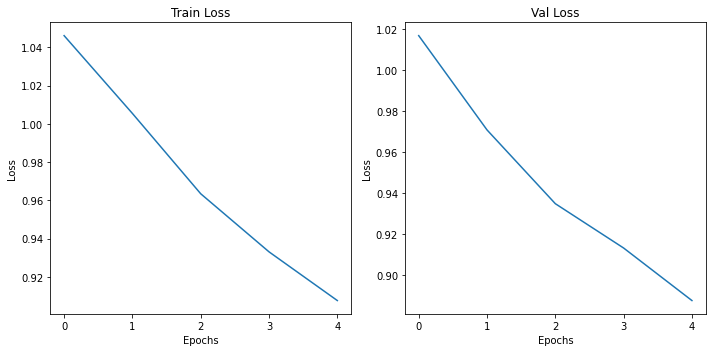

In [36]:
display(HTML("""

"""))
fig, (ax1, ax2)=plt.subplots(1,2) 
ax1.plot(train_loss_hist) 
ax2.plot(val_loss_hist)
ax1.set_title("Train Loss") 
ax2.set_title("Val Loss") 
ax1.set_ylabel("Loss") 
ax1.set_xlabel("Epochs") 
ax2.set_ylabel("Loss") 
ax2.set_xlabel("Epochs") 
ax1.set_xticks(range(5)) 
ax2.set_xticks(range(5)) 
fig.set_size_inches(10, 5) 
fig.tight_layout() 
fig.savefig('DLILab1.png', bbox_inches='tight')

In [35]:
end=time.time()
print("Total runtime: {:.2f} seconds".format(end-start))

Total runtime: 653.12 seconds
